In [20]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import seaborn as sns
import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

def compute_spot_size(adata, gene_symbol, size):
    r""" returns a vector with the size of the spots. Areas where no expression is observed for a given
    gene are set to size zero.
    
    :param adata: Anndata object
    :param gene_symbol: Gene Symbol for whom we explore gene expression
    :param size: size for the spots when their expression is different from zero.
    """
    index=adata.var[adata.var["SYMBOL"]== gene_symbol].index.values[0]
    expression_values = adata.X.todense()[:,adata.var.index.get_loc(index)]
    for x in range(len(expression_values)):
        if expression_values[x] > 0:
            expression_values[x] = size
        else:
            expression_values[x] = 0
    
    
    return expression_values.tolist()

# Load spatial data

In [ ]:
InputDir = './Spatial/Gastric/21_00734_LI_SING/'
adata = sc.read_visium(InputDir)
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
print(f"#cells before MT filter: {adata.n_obs}")
sc.pp.filter_cells(adata, min_counts=1000)
sc.pp.filter_cells(adata, max_counts=40000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)
adata_vis = adata.copy()


## scRNA process

In [ ]:
adata = sc.read_h5ad('./data/RawData.h5ad')
ProcessMeta = pd.read_table('./data/Processed.meta.txt', index_col = 0)
MeloidMeta = pd.read_table('./data/Macro&DC.meta.txt', index_col = 0)
LyphMeta = pd.read_table('./data/T&NK.meta.txt', index_col = 0)
EpiMeta = pd.read_table('./data/Epi.meta.txt', index_col = 0)
UMAP = pd.read_table('./data/UMAP.txt', index_col = 0)
Celltype = {0: 'T&NK'
, 1: 'T&NK'
, 2: 'PB'
, 3: 'Macro'
, 4: 'Epi'
, 5: 'Fibroblast'
, 6: 'B'
, 7: 'Endothelia'
, 8: 'Mast Cell'
, 9: 'Pericyte'
, 10:'T&NK'
, 11:'PB'
, 12:'Epi'}

TNK = {0:'CD8+ T', 1:'CD4+ T', 2:'CD4+ T', 3:'NK', 4:'NK', 5:'CD8+ T', 6:'CD8+ T', 7:'CD8+ T'}
MD = {0:'Macro', 1:'Macro', 2:'Macro', 3:'Macro', 4:'DC', 5:'Macro', 6:'Macro', 7:'Macro', 8:'DC', 9:'Macro', 10:'Macro'}
Epi = {0:'Epi_1', 1:'Epi_2', 2:'Epi_3', 3:'Epi_4', 4:'Epi_5', 5:'Epi_6', 6:'Epi_7', 7:'Epi_8', 8:'Epi_9', 9:'Epi_10', 10:'Epi_11', 11:'Epi_12', 12:'Epi_13'}

adata.obs['CellInfo'] = ProcessMeta.loc[adata.obs.index, 'seurat_clusters']
adata.obs['CellInfo'] = [Celltype[x] for x in adata.obs['CellInfo']]

adata.obs.loc[MeloidMeta.index, 'CellInfo'] = MeloidMeta['seurat_clusters']
adata.obs.loc[MeloidMeta.index, 'CellInfo'] = [MD[x] for x in adata.obs.loc[MeloidMeta.index, 'CellInfo']]

adata.obs.loc[LyphMeta.index, 'CellInfo'] = LyphMeta['seurat_clusters']
adata.obs.loc[LyphMeta.index, 'CellInfo'] = [TNK[x] for x in adata.obs.loc[LyphMeta.index, 'CellInfo']]

adata.obs.loc[EpiMeta.index, 'CellInfo'] = EpiMeta['seurat_clusters']
adata.obs.loc[EpiMeta.index, 'CellInfo'] = [Epi[x] for x in adata.obs.loc[EpiMeta.index, 'CellInfo']]

adata.obsm['umap'] = np.array(UMAP)

with mpl.rc_context({'figure.figsize': [6,6],
                     'axes.facecolor': 'white'}):
    sc.pl.umap(adata, color=['CellInfo'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=10)
adata.write('./data/adataRaw.h5ad')    

adata_ref = sc.read_h5ad('./data/adataRaw.h5ad')
adata_ref.obs['CellInfo'] = [x if 'Epi' not in x else 'Epi' for x in adata_ref.obs['CellInfo']]

ref_run_name = './Spatial/scRNA/Gastric/Signiture/'
import cell2location
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object

In [ ]:
# filter the object
adata_ref = adata_ref[:, selected].copy()

# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='CellInfo',
                       )

# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

mod.train(max_epochs=250, use_gpu=False)
mod.plot_history(20)

# export the estimated cell abundance 

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).

adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': False}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

In [ ]:
adata_ref = mod.export_posterior(
    adata_ref, use_quantiles=True,
    # choose quantiles
    add_to_varm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': 2500, 'use_gpu': False}
)

adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)
mod.plot_QC()

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]


# find shared genes

In [ ]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis)

# create and train the model

In [ ]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=20,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=100
)
mod.view_anndata_setup()

In [ ]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)
mod.plot_QC()

# Plot 

In [10]:
import pandas as pd
Genes = pd.read_table('./ISGgene.txt', header = None)
gene_list = Genes[0].tolist()
Prefix = '21_00734_LI_SING'

InputDir = './Spatial/Gastric/' + Prefix + '/'
adata_vis = sc.read_visium(InputDir)
adata_vis.var_names_make_unique()
sc.pl.spatial(adata_vis, img_key="hires")
adata_vis

AnnData object with n_obs × n_vars = 3577 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [11]:
spatial_run_name = './Spatial/Gastric/Signiture/' + Prefix + '/'
adata_decon = sc.read_h5ad(spatial_run_name + '/sp.h5ad')
adata_vis = adata_vis[adata_decon.obs.index, ]
sc.pp.filter_genes(adata_vis, min_cells=10)
adata_vis.obs = adata_decon.obs.loc[adata_vis.obs.index]
adata_vis.uns = adata_decon.uns

PredictPor = adata_vis.obs[adata_vis.obs[adata_vis.uns['mod']['factor_names']].columns.tolist()].T/adata_vis.obs[adata_vis.obs[adata_vis.uns['mod']['factor_names']].columns.tolist()].sum(1)
PredictedCell = adata_vis.obs[adata_vis.obs[adata_vis.uns['mod']['factor_names']].columns.tolist()].columns
for celltype in PredictedCell:
    adata_vis.obs[celltype] = PredictPor.T.loc[adata_vis.obs.index, celltype]
adata_vis.obs[PredictedCell].sum(1)
adata_vis.obs['Norm-like Epi'] = adata_vis.obs['Epi']
adata_vis.obs['Tumor-like Epi'] = adata_vis.obs['Tumor']

#with mpl.rc_context({'figure.figsize': (12, 10), "font.size": 18}):
#    sc.pl.spatial(adata_vis, color=adata_vis.obs[adata_vis.uns['mod']['factor_names']].columns.tolist(), size=1.25, color_map = "Reds", use_raw=False, alpha_img = 0, ncols=4)
    

In [12]:
sc.pp.normalize_total(adata_vis, inplace=True)
sc.pp.log1p(adata_vis)


In [13]:
sc.tl.score_genes(adata_vis, gene_list, score_name='ISG score', use_raw = False, n_bins=38)

In [14]:
adata = adata_vis.copy()
slide = adata_vis.copy()

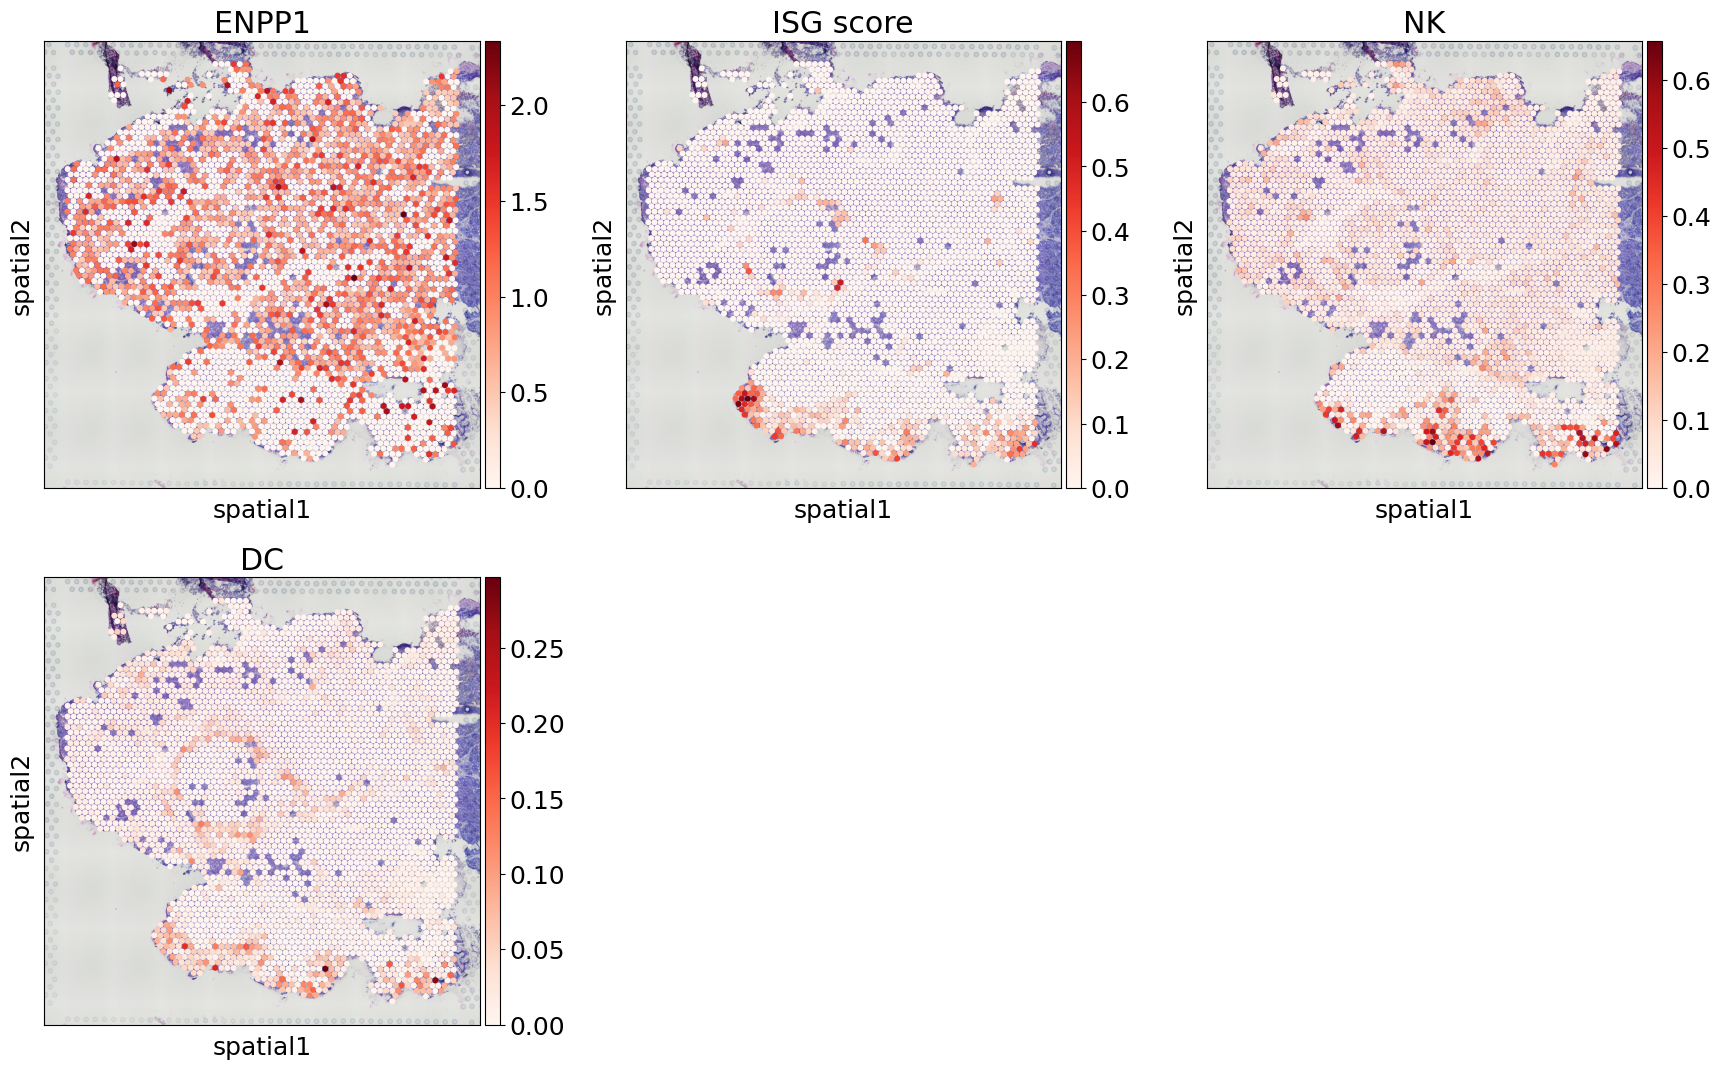

In [19]:
Targets = ['ENPP1', 'ISG score', 'NK', 'DC']
with mpl.rc_context({'figure.figsize': (6,6), "font.size": 18}):
    sc.pl.spatial(slide, color=Targets, size=1.5, color_map = "Reds", use_raw=False, vmin = 0, alpha_img = 1, ncols=3, hspace=0.2, wspace=0.16)
